<a href="https://colab.research.google.com/github/bodhivani/RAVEfold/blob/main/heavydemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install ColabFold
# setup device
from IPython.display import clear_output
!mkdir struct_gen
%cd /content/struct_gen/.
clear_output()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import tensorflow as tf
import jax

try:
  # check if TPU is available
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Running on TPU')
  DEVICE = "tpu"
except:
  if jax.local_devices()[0].platform == 'cpu':
    print("WARNING: no GPU detected, will be using CPU")
    DEVICE = "cpu"
  else:
    print('Running on GPU')
    DEVICE = "gpu"
    # disable GPU on tensorflow
    tf.config.set_visible_devices([], 'GPU')

from IPython.utils import io
import subprocess
import tqdm.notebook


install_jackhmmer = True      #not required

#AF2 repo from deepmind
GIT_REPO = 'https://github.com/deepmind/alphafold'
#AF2 params
SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'

PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))

TMP_DIR = "tmp"
os.makedirs(TMP_DIR, exist_ok=True)

#tqdm specification
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
# if not already installed
total = 55
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  if not os.path.isdir("alphafold"):
    # download alphafold code and clone colabfold repo
    os.system(f"git clone {GIT_REPO} alphafold; cd alphafold; git checkout 1d43aaff941c84dc56311076b58795797e49107b")
    os.system(f"git clone https://github.com/sokrypton/ColabFold.git")

    # apply patches
    os.system(f"patch -u alphafold/alphafold/model/model.py -i ColabFold/beta/model.patch")
    os.system(f"patch -u alphafold/alphafold/model/mapping.py -i ColabFold/beta/mapping.patch")
    os.system(f"patch -u alphafold/alphafold/model/modules.py -i ColabFold/beta/modules.patch")
    os.system(f"patch -u alphafold/alphafold/model/folding.py -i ColabFold/beta/folding.patch")
    os.system(f"patch -u alphafold/alphafold/model/config.py -i ColabFold/beta/config.patch")
    # apply multi-chain patch from Lim Heo @huhlim
    os.system(f"patch -u alphafold/alphafold/common/protein.py -i ColabFold/beta/protein.patch")
    pbar.update(4)

    #install biopython
    os.system(f"pip install biopython dm-haiku==0.0.5 ml-collections py3Dmol")
    pbar.update(6)

    # download model params (speedup from kaczmarj)
    os.system(f"mkdir --parents {PARAMS_DIR}")
    os.system(f"curl -fsSL {SOURCE_URL} | tar x -C {PARAMS_DIR}")
    pbar.update(14+27)

    # install hhsuite
    os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C {TMP_DIR}/")

    # install jackhmmer   #not required and will remove it
    if install_jackhmmer:
      os.system(f"sudo apt install --quiet --yes hmmer")
      pbar.update(3)

      # create a ramdisk to store a database chunk to make Jackhmmer run fast.
      os.system(f"sudo mkdir -m 777 --parents /tmp/ramdisk")
      os.system(f"sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk")
      pbar.update(1)

    else:
      pbar.update(4)

  else:
    pbar.update(55)

###############################################################################################
####    Python imports 
###############################################################################################
if 'alphafold' not in sys.path:
  sys.path.append('alphafold')
if 'ColabFold/beta' not in sys.path:
  sys.path.append('ColabFold/beta')

if f"{TMP_DIR}/bin" not in os.environ['PATH']:
  os.environ['PATH'] += f":{TMP_DIR}/bin:{TMP_DIR}/scripts"

import colabfold as cf
import colabfold_alphafold as cf_af

import json
import matplotlib.pyplot as plt
import numpy as np

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

!cd ..

In [ ]:
#@title Run Colabfold with reduced MSA
#Code was taken from COLABFOLD git and modified for convenience 
import re
import time
from IPython.display import clear_output

%cd /content/struct_gen/.
#####################################################################################################################
###    Input sequence
#####################################################################################################################

#@markdown Change this to the amino acid sequence of your system
sequence = 'MQRGKVKWFNNEKGYGFIEVEGGSDVFVHFTAIQGEGFKTLEEGQEVSFEIVQGNRGPQAANVVKE' #@param {type:"string"}
jobname = "CSP" #@param {type:"string"}
homooligomer =  "1" #param {type:"string"}


#####################################################################################################################
###    MSA parameters
#####################################################################################################################

cd 
add_custom_msa = False 
msa_format = "fas" 
pair_mode = "unpaired" 
pair_cov = 50 
pair_qid = 20 

I = cf_af.prep_inputs(sequence, jobname, homooligomer, clean=IN_COLAB)
msa_method = "mmseqs2" 
#I['output_dir']='_'.join(I['output_dir'].split('_')[:-1])
I = cf_af.prep_msa(I, msa_method, add_custom_msa, msa_format,
                   pair_mode, pair_cov, pair_qid, TMP_DIR=TMP_DIR)
mod_I = I
clear_output() # ----> Clear the output from previous functions
#No relaxation 
num_relax = "None"


#####################################################################################################################
###    Parameters for running Alphafold
#####################################################################################################################
rank_by = "pLDDT" 
use_turbo = True 
#@markdown This parameter can be "tuned". Too low, and it doesn't have enough information for sensible predictions. Too high, and it will not generate structural diversity
max_msa = "08:16" #@param ["512:1024", "256:512", "128:256", "64:128", "32:64","16:32","08:16","04:08","02:04","01:02","02:02"]
#@markdown - `max_msa` defines: `max_msa_clusters:max_extra_msa` number of sequences to use. 
max_msa_clusters, max_extra_msa = [int(x) for x in max_msa.split(":")]

show_images = False 

num_models = 5 
use_ptm = True 
num_ensemble = 1 
max_recycles = 1 
is_training = True 
num_samples = 128 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
#@markdown - `num_samples` defines the number of random seed. (For each seed 5 different models are predicted)  
subsample_msa = True 

if not use_ptm and rank_by == "pTMscore":
  print("WARNING: models will be ranked by pLDDT, 'use_ptm' is needed to compute pTMscore")
  rank_by = "pLDDT"

# prep input features
feature_dict = cf_af.prep_feats(mod_I, clean=IN_COLAB)
Ls_plot = feature_dict["Ls"]

# prep model options
opt = {"N":len(feature_dict["msa"]),
       "L":len(feature_dict["residue_index"]),
       "use_ptm":use_ptm,
       "use_turbo":use_turbo,
       "max_recycles":max_recycles,
       "tol":0.0,
       "num_ensemble":num_ensemble,
       "max_msa_clusters":max_msa_clusters,
       "max_extra_msa":max_extra_msa,
       "is_training":is_training}

if use_turbo:
  if "runner" in dir():
    # only recompile if options changed
    runner = cf_af.prep_model_runner(opt, old_runner=runner)
  else:
    runner = cf_af.prep_model_runner(opt)
else:
  runner = None

#####################################################################################################################
###    Run Alphafold with low MSA 
#####################################################################################################################
t1 = time.perf_counter()
outs, model_rank = cf_af.run_alphafold(feature_dict, opt, runner, num_models, num_samples, subsample_msa,
                                       rank_by=rank_by, show_images=show_images)



#####################################################################################################################
###    Output folder
#####################################################################################################################

structures_path='/content/Structures'   #Output_folder
os.makedirs(structures_path)
file_path=os.path.join(structures_path,'file_details.txt')
with open(file_path, "w") as file_details:
  for n,key in enumerate(model_rank):
    copy_line=f'cp {I["output_dir"]}/rank_{n+1}_{key}_unrelaxed.pdb {structures_path}/pred_{n+1}.pdb'
    os.system(copy_line)
    if num_relax !="None":
      if n<num_relax: 
        copy_line2=f'cp {I["output_dir"]}/rank_{n+1}_{key}_relaxed.pdb {structures_path}/pred_{n+1}.pdb'
        os.system(copy_line2)
    line = f"pred_{n+1}.pdb pLDDT:{outs[key]['pLDDT']:.2f}" + f" pTMscore:{outs[key]['pTMscore']:.4f}" if use_ptm else ""
    file_details.write(line+"\n")

#os.system(f'rm -r {I[output_dir]}')   #--> run this line to delete the second copy of structures
%cd /content/
os.system(f'zip -FSr Structures.zip {structures_path}')
t2 = time.perf_counter()
clear_output()
print('\nTime taken to generate:',(t2-t1)/60,' mins')

print(f'The structures can be found in {structures_path}')

In [5]:
#@title Install condacolab
#@markdown After running this cell wait for the kernel to restart (~1min)

#@markdown Then, start running the rest of the blocks
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [1]:
#@title Install OpenMM with Plumed
#@markdown Run this to install and import libraries 
import time
t1 = time.perf_counter()
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    !conda install -q -y -c conda-forge mdtraj openmm cudatoolkit=11.2 openmmforcefields openmm-plumed 
    
    # for gromacs forcefield files (for conversion from GMX)
    %cd /content/Plumed-on-OpenMM-GPU/
    !tar -zxvf gromacsff.tar.gz
    %cp -r CSP_reqFiles /content/test_MD
    %cd /content/test_MD
    
    on_colab = True
    clear_output()             # clear the excessive installation outputs (disable incase of error check)
    print("Dependencies successfully installed and imported!")
except ModuleNotFoundError:
    on_colab = False

!pwd

# required for simulation with Plumed on gpu
from sys import stdout
from openmmplumed import PlumedForce
from openmm.app import *
from openmm import *
from openmm.unit import *

# required for analysis
import numpy as np
import matplotlib.pyplot as plt

t2 = time.perf_counter()
print('time taken to run:',t2-t1)

#create the directory for colabfold


Dependencies successfully installed and imported!
/content


time taken to run: 370.15985097099997


In [2]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt

!rm -r RAVEfold 
!git clone https://github.com/bodhivani/RAVEfold

!cp RAVEfold/ravefuncs.py .
import ravefuncs as rave

Cloning into 'RAVEfold'...
remote: Enumerating objects: 127, done.
remote: Total 127 (delta 0), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (127/127), 6.36 MiB | 19.97 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [6]:
#@title Analysis on AF2 structures
if os.path.isdir("Structures")==False:
  os.system("unzip RAVEfold/CSP_data/structures.zip -d .")
  num_samples=128

tot=num_samples*5
os.chdir("Structures")
!cp ../RAVEfold/CSP_data/plumed_AF2.dat .
inputline=' '.join([f'pred_{i+1}.pdb' for i in range(tot)])
os.system(f'mdconvert {inputline} -o AF2samples.xtc')
os.system('plumed driver --plumed plumed_AF2.dat --ixtc AF2samples.xtc')
os.chdir("..")

In [5]:
num_samples=128

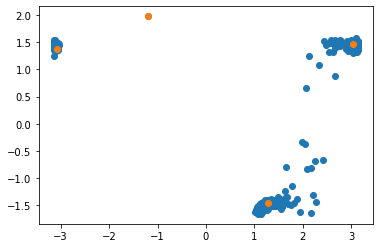

In [19]:
#@title Cluster to initialize RAVEfold
CVs=np.loadtxt("Structures/COLVARS_AF2.dat")[:,1:]
centers,listindices=rave.RegSpaceClustering(CVs,6.5,max_centers=10, batch_size=50) #change to 5 or 5.5 for robustness
t_af2=rave.getTrp8(CVs)
t_cluster=rave.getTrp8(centers.T)

plt.plot(t_af2[0],t_af2[1],"o")
plt.plot(t_cluster[0],t_cluster[1],"o")

In [ ]:
#@title Unbiased simulations

#@markdown Check the below box to run on GPU
on_gpu=True #@param {type:"boolean"}
#@markdown MD parameters

#@markdown Integration Timestep (ps)
dt =0.002 #@param{type:"number"}
#@markdown Temperature (K)
temp=300 #@param{type:"number"}
freq=1 #param{type:"number"}
#@markdown Number of steps 
nstep=500000 #@param{type:"number"}
#@markdown Plumed file
plumedfile="plumed_full.dat" #@param{type:"string"}

os.mkdir("unbiased")
os.chdir("unbiased")
for index in listindices:
  os.mkdir("%i"%index)
  os.cp("structures/pred_%i/ %i"%(index,index))
  os.chdir("%i"%(index))
  run_unbiased(on_gpu,dt,temp,freq,nstep,index)
  os.chdir("..")

os.chdir("..")


In [ ]:
#@title SPIB on unbiased simulations
cvs=[]
os.mkdir("SPIB_unbiased")
os.chdir("SPIB_unbiased")

for i,index in enumerate(listindices):
    cvs.append(np.loadtxt("../unbiased/%i/colvar.dat"%index))
    np.save("colvar_%i_unb.npy"%i,cvs[i])
    lentraj=len(cvs[i])
    zeroone=np.hstack([np.zeros(int(lentraj/2),dtype=np.int8),np.ones(lentraj-int(lentraj/2),dtype=np.int8)])
    initlabels=np.eye(num_state)[zeroone+int(i*2)]
    np.save("labels_%i_unb.npy"%i,initlabels)

!cp RAVEfold/sample_config.ini config.ini

f= open("sample_config.ini","a")

f.write("\n traj_data = [%s]"%(",".join["colvar_%i_unb.npy"%i for i in len(cvs)]))

f.write("\n initial_labels = [%s]"%(",".join["labels_%i_unb.npy"%i for i in len(cvs)]))

In [ ]:
%run State-Predictive-Information-Bottleneck/test_model_advanced.py config.ini

In [ ]:
prefix='SPIB/Unweighted_d=1_t=50_b=0.0100_learn=0.001000_'
weights=np.load(prefix+"z_mean_encoder_weight0.npy")
plt.plot(weights)

lspace=[np.load(prefix+"traj%i_mean_representation0.npy"%i) for i in range(len(cvs))]


In [ ]:
#@title Biased simulations

#@markdown Here we are using already solvated and equilibrated system(from GMX)

# Inputs definition 

#@markdown metadynamics parameters
height = 1.5 #@param{type:"number"}
biasfactor=10 #@param{type:"number"}
#@markdown standard deviation of deposited gaussians
width1= 1 #@param{type:"number"}
width2= 1 #@param{type:"number"}
#@markdown metadynamics gridparameters
gridmin1=1 #@param{type:"number"}
gridmin2=1 #@param{type:"number"}
gridmax1=1 #@param{type:"number"}
gridmax2=1 #@param{type:"number"}
#@markdown Length of metadynamics simulation


!cp RAVEfold/CSPdata/plumed_full.dat . plumed_biased.dat
colvar="sc1_r1,cc1_r1,sc1_r2,cc1_r2,sc1_r3,cc1_r3,sc1_r5,cc1_r5,sc1_r6,cc1_r6,sc1_r7,cc1_r7,sc1_r8,cc1_r8,sc1_r9,cc1_r9,sc1_r10,cc1_r10,sc1_r11,cc1_r11,sc1_r12,cc1_r12,sc1_r13,cc1_r13,sc1_r15,cc1_r15,sc1_r17,cc1_r17,sc1_r18,cc1_r18,sc1_r19,cc1_r19,sc1_r20,cc1_r20,sc1_r21,cc1_r21,sc1_r24,cc1_r24,sc1_r25,cc1_r25,sc1_r26,cc1_r26,sc1_r27,cc1_r27,sc1_r28,cc1_r28,sc1_r29,cc1_r29,sc1_r30,cc1_r30,sc1_r31,cc1_r31,sc1_r33,cc1_r33,sc1_r34,cc1_r34,sc1_r36,cc1_r36,sc1_r38,cc1_r38,sc1_r39,cc1_r39,sc1_r40,cc1_r40,sc1_r41,cc1_r41,sc1_r42,cc1_r42,sc1_r43,cc1_r43,sc1_r45,cc1_r45,sc1_r46,cc1_r46,sc1_r47,cc1_r47,sc1_r48,cc1_r48,sc1_r49,cc1_r49,sc1_r50,cc1_r50,sc1_r51,cc1_r51,sc1_r52,cc1_r52,sc1_r53,cc1_r53,sc1_r55,cc1_r55,sc1_r56,cc1_r56,sc1_r58,cc1_r58,sc1_r59,cc1_r59,sc1_r62,cc1_r62,sc1_r63,cc1_r63,sc1_r64,cc1_r64,sc1_r65,cc1_r65,sc1_r66,cc1_r66,sc2_r1,cc2_r1,sc2_r2,cc2_r2,sc2_r3,cc2_r3,sc2_r5,cc2_r5,sc2_r7,cc2_r7,sc2_r8,cc2_r8,sc2_r9,cc2_r9,sc2_r10,cc2_r10,sc2_r11,cc2_r11,sc2_r12,cc2_r12,sc2_r13,cc2_r13,sc2_r15,cc2_r15,sc2_r17,cc2_r17,sc2_r18,cc2_r18,sc2_r19,cc2_r19,sc2_r21,cc2_r21,sc2_r25,cc2_r25,sc2_r27,cc2_r27,sc2_r29,cc2_r29,sc2_r30,cc2_r30,sc2_r33,cc2_r33,sc2_r34,cc2_r34,sc2_r36,cc2_r36,sc2_r38,cc2_r38,sc2_r39,cc2_r39,sc2_r41,cc2_r41,sc2_r42,cc2_r42,sc2_r43,cc2_r43,sc2_r45,cc2_r45,sc2_r46,cc2_r46,sc2_r49,cc2_r49,sc2_r50,cc2_r50,sc2_r51,cc2_r51,sc2_r53,cc2_r53,sc2_r55,cc2_r55,sc2_r56,cc2_r56,sc2_r58,cc2_r58,sc2_r59,cc2_r59,sc2_r62,cc2_r62,sc2_r65,cc2_r65,sc2_r66,cc2_r66,sc3_r1,cc3_r1,sc3_r2,cc3_r2,sc3_r3,cc3_r3,sc3_r5,cc3_r5,sc3_r7,cc3_r7,sc3_r12,cc3_r12,sc3_r13,cc3_r13,sc3_r19,cc3_r19,sc3_r21,cc3_r21,sc3_r34,cc3_r34,sc3_r36,cc3_r36,sc3_r39,cc3_r39,sc3_r42,cc3_r42,sc3_r43,cc3_r43,sc3_r45,cc3_r45,sc3_r46,cc3_r46,sc3_r50,cc3_r50,sc3_r53,cc3_r53,sc3_r56,cc3_r56,sc3_r59,cc3_r59,sc3_r65,cc3_r65,sc3_r66,cc3_r66,sc4_r3,cc4_r3,sc4_r5,cc4_r5,sc4_r7,cc4_r7,sc4_r13,cc4_r13,sc4_r39,cc4_r39,sc4_r56,cc4_r56,sc4_r65,cc4_r65,sc5_r3,cc5_r3,sc5_r56,cc5_r56"
plumedfile="plumed_biased.dat"
make_biased_plumed(plumedfile,weights,colvar,height,biasfactor,width1,width2,gridmin1,gridmin2,gridmax1,gridmax2)

pdbfile="Structures/pred_1.pdb"
run_biased_plumed(pdbfile,time)

In [ ]:
num_traj=len(indices)

num_traj=len(indices)

cvs=[]
for i in indices:
    cvs.append(np.genfromtxt("allchis/chis_%i.dat"%i)[:,1:])

data=np.vstack(cvs).T
w=np.exp(data[-1]/kbT)
#%%
    
T=[50,50]
nT=len(T)
fig, ax = plt.subplots(nT,figsize=(5,5*nT))
for k,t in enumerate(T):
    prefix='SPIB/Unweighted_d=2_t=%i_b=0.0100_learn=0.010000'%t
    repeat='0'
    traj_mean_rep=np.vstack([np.load(prefix+"_traj%i_mean_representation"%i+repeat+".npy") for i in range(num_traj)]).T
    H,xlims,ylims=np.histogram2d(traj_mean_rep[0],traj_mean_rep[1],weights=w,bins=100)

    xlims=(xlims[1:]+xlims[:-1])/2
    ylims=(ylims[1:]+ylims[:-1])/2
    im=ax[k].contourf(xlims,ylims,-np.log(H).T+np.max(np.log(H)),cmap="plasma",LineWidth=1)
    
    fig.colorbar(im,ax=ax[k],label="PMF/$k_BT$")
    ax[k].set_aspect('equal')
    ax[k].set_xlabel("$\sigma_1$ ")
    ax[k].set_ylabel("$\sigma_2$ ")
    ax[k].set_title("$\\tau=%i$"%t)
    
    np.save("../pmf_cvSPIB_mdSPIB",H)
    np.save("../xy_cvSPIB_mdSPIB",[xlims,ylims])

plt.savefig("pmf_cvtrp8_mdSPIB",dpi=500, bbox_inches='tight')
plt.show()
  
  


#%%
  
  
  
#  labels=np.vstack([np.load(prefix+"_traj%i_labels"%i+repeat+".npy") for i in range(num_traj)])
#
#  check=labels.sum(axis=0).nonzero()
#  labels=labels[:,check[0]]
#  print(labels.shape)
#  state_num=labels.shape[1]
#  state_labels=np.arange(state_num)
#
##  ax[2*k,0].set(ylabel="states")
#  (cv0,cv1)=(6,len(resids[0])+5)
#  hist=np.histogram2d(data[:,cv0],data[:,cv1],bins=100)
#  hist_state=np.zeros([state_num]+list(hist[0].shape))
#
#  for i in range(state_num):
#      hist_state[i]=np.histogram2d(data[:,cv0],data[:,cv1],bins=[hist[1],hist[2]],weights=labels[:,i])[0]
#        
#  label_map=np.argmax(hist_state,axis=0).astype(float)
#  label_map[hist[0]==0]=np.nan
#
#
#
#  fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
#  tickz = np.arange(0,len(state_labels))
#
#  cMap = c.ListedColormap(plt.cm.tab20.colors[0:state_num])
#  im=ax[k,0].pcolormesh(hist[1], hist[2], label_map.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
#
#
#  ax[k,0].set_title("dt=%i"%(t))
#  ax[k,0].set_xlabel("$\chi_1$")
#  ax[k,0].set_ylabel("$\chi_2$")
#
#  cb1 = fig.colorbar(im,ax=ax[k,0],format=fmt, ticks=tickz)
#
#  hist=np.histogram2d(data[:,cv0],data[:,cv1],bins=100)
#  hist_RC=np.histogram2d(data[:,cv0],data[:,cv1],bins=[hist[1],hist[2]],weights=traj_mean_rep[:,0])
#
#  RC=np.divide(hist_RC[0],hist[0])
#
#
#  im=ax[k,1].contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]])#,levels=10 ,cmap=plt.cm.jet)
#  ax[k,1].set_xlabel("$\chi_1$")
#  ax[k,1].set_ylabel("$\chi_2$")
#
#  fig.colorbar(im,ax=ax[k,1])
#
#  hist=np.histogram2d(data[:,cv0],data[:,cv1],bins=100)
#  hist_RC=np.histogram2d(data[:,cv0],data[:,cv1],bins=[hist[1],hist[2]],weights=traj_mean_rep[:,1])
#
#  RC=np.divide(hist_RC[0],hist[0])
#
#
#  im=ax[k,2].contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]])#,levels=10 ,cmap=plt.cm.jet)
#  ax[k,2].set_xlabel("$\chi_1$")
#  ax[k,2].set_ylabel("$\chi_2$")
#
#  fig.colorbar(im,ax=ax[k,2])
#
#
#[a.set_aspect("equal") for b in ax[:,:-1] for a in b]
##plt.subplots_adjust(wspace=0.5, hspace=0.5)
##fig.tight_layout()
#plt.savefig("fulldat.png")
#

#%%
#num_traj=len(traj_labels)
#num_cv=len(cvlist)
#
#data=[np.genfromtxt("../allCVs_%i"%i)[:,1:1+num_cv] for i in range(num_traj)]
#t_lens=[len(d) for d in data] 
#data=np.vstack(data)
#
##%%
#t_labels=np.eye(num_traj)[np.hstack([np.ones(l,dtype=np.int8)*i for i,l in enumerate(t_lens)])]
#    
##%%
#
#T=[20000]#,15000,20000]
#nT=len(T)
#
#
##%%
#for k,t in enumerate(T):
#  prefix='SPIB/Unweighted_d=2_t=%i_b=0.0100_learn=0.010000'%t
#  repeat='0'
#  traj_mean_rep=np.vstack([np.load(prefix+"_traj%i_mean_representation"%i+repeat+".npy") for i in range(num_traj)])
#  labels=np.vstack([np.load(prefix+"_traj%i_labels"%i+repeat+".npy") for i in range(num_traj)])
#
#  check=labels.sum(axis=0).nonzero()
#
#  labels=labels[:,check[0]]
#
#  num_state=labels.shape[1]
#  state_labels=np.arange(num_state)
##%%
#  fig, ax = plt.subplots(2,6,figsize=(30,10))
#  
##states on all input OPs
#  for j,(cv0,cv1) in enumerate(((0,1),(2,3),(5,6),(7,8),(9,10),(4,11))):
#    hist=np.histogram2d(data[:,cv0],data[:,cv1],bins=100)
#    hist_state=np.zeros([num_state]+list(hist[0].shape))
#    nl=10
#    cMap = cm.rainbow(np.linspace(0, 1, num_state))
#    for i in range(num_state):
#      hist_state[i]=np.histogram2d(data[:,cv0],data[:,cv1],bins=[hist[1],hist[2]],weights=labels[:,i],density=True)[0]
#      mx,mn=hist_state[i].max(),hist_state[i].min()
#      ax[1,j].contour(hist_state[i].T,extent=[hist[1][0],hist[1][-1],hist[2][0],hist[2][-1]],levels=np.arange(mn,mx+1,(mx-mn)/nl),colors=np.outer(np.ones(10),cMap[i]))
#      
#    
#      ax[1,j].set_xlabel("%s"%(cvs_nmr.all[cv0].name))
#      ax[1,j].set_ylabel("%s"%(cvs_nmr.all[cv1].name))
#      
##  for j,cv in enumerate((4,11)):
##    hist=np.histogram(data[:,cv],bins=100)
##    hist_state=np.zeros([num_state]+list(hist[0].shape))
##    nl=10
##    cMap = cm.rainbow(np.linspace(0, 1, num_state))
##    x=(hist[1][:-1]+hist[1][1:])/2
##    for i in range(num_state):
##      hist_state[i]=np.histogram(data[:,cv],bins=hist[1],weights=labels[:,i],density=True)[0]
##      mx,mn=hist_state[i].max(),hist_state[i].min()
##      ax[1,-j-1].plot(x,hist_state[i],color=cMap[i])
##      
##    
##      ax[1,-j-1].set_xlabel("%s"%(cvlist[cv]))
#
##trajectories on all input OPs
#
#  for j,(cv0,cv1) in enumerate(((0,1),(2,3),(5,6),(7,8),(9,10),(4,11))):
#    hist=np.histogram2d(data[:,cv0],data[:,cv1],bins=100)
#    hist_traj=np.zeros([num_traj]+list(hist[0].shape))
#    nl=10
#    cMap = cm.rainbow(np.linspace(0, 1, num_traj))
#    for i in range(num_traj):
#      hist_traj[i]=np.histogram2d(data[:,cv0],data[:,cv1],bins=[hist[1],hist[2]],weights=t_labels[:,i])[0]
#      mx,mn=hist_traj[i].max(),hist_traj[i].min()
#      ax[0,j].contour(hist_traj[i].T,extent=[hist[1][0],hist[1][-1],hist[2][0],hist[2][-1]],levels=np.arange(mn,mx+1,(mx-mn)/nl),colors=np.outer(np.ones(10),cMap[i]))
#      
#    
#      ax[0,j].set_xlabel("%s"%(cvs_nmr.all[cv0].name))
#      ax[0,j].set_ylabel("%s"%(cvs_nmr.all[cv1].name))    
#
#  lines =[Line2D([0], [0], label=traj_labels[i], color=cMap[i]) for i in range(num_traj)]
#  ax[0,4].legend(handles=lines,framealpha=0)
#  
##  
##  for j,cv in enumerate((4,11)):
##    hist=np.histogram(data[:,cv],bins=100)
##    hist_traj=np.zeros([num_traj]+list(hist[0].shape))
##    nl=10
##    cMap = cm.rainbow(np.linspace(0, 1, num_traj))
##    x=(hist[1][:-1]+hist[1][1:])/2
##    for i in range(num_traj):
##      hist_traj[i]=np.histogram(data[:,cv],bins=hist[1],weights=t_labels[:,i],density=True)[0]
##      mx,mn=hist_traj[i].max(),hist_traj[i].min()
##      ax[1,-j-1].plot(x,hist_traj[i],color=cMap[i])
##      
##    
##      ax[1,-j-1].set_xlabel("%s"%(cvlist[cv]))
#  
#  plt.savefig("og_cv_projections_%i"%t)
##%%
#  fig, ax = plt.subplots(2,7,figsize=(20,10))  
##RC on CV projections
#  for j,(cv0,cv1) in enumerate(((0,1),(2,3),(5,6),(7,8),(9,10))):
#    hist=np.histogram2d(data[:,cv0],data[:,cv1],bins=100)
#    hist_RC=np.histogram2d(data[:,cv0],data[:,cv1],bins=[hist[1],hist[2]],weights=traj_mean_rep[:,0])
#
#    RC=np.divide(hist_RC[0],hist[0])
#
#
#    im=ax[1,j].contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]])#,levels=10 ,cmap=plt.cm.jet)
#    ax[1,j].set_xlabel("%s"%(cvlist[cv0]))
#    ax[1,j].set_ylabel("%s"%(cvlist[cv1]))
#
#    hist_state=np.zeros([num_state]+list(hist[0].shape))
#    nl=10
#    cMap = cm.rainbow(np.linspace(0, 1, num_state))
#    
#    
#    for i in range(num_state):
#      hist_state[i]=np.histogram2d(data[:,cv0],data[:,cv1],bins=[hist[1],hist[2]],weights=labels[:,i])[0]
#      mx,mn=hist_state[i].max(),hist_state[i].min()
#      ax[0,j].contour(hist_state[i].T,extent=[hist[1][0],hist[1][-1],hist[2][0],hist[2][-1]],levels=np.arange(mn,mx+1,(mx-mn)/nl),colors=np.outer(np.ones(10),cMap[i]))
#      
#    
#      ax[0,j].set_xlabel("%s"%(cvlist[cv0]))
#      ax[0,j].set_ylabel("%s"%(cvlist[cv1]))    
#
#  fig, ax = plt.subplots(2,5,figsize=(20,10))
#
#  for j,(cv0,cv1) in enumerate(((0,1),(2,3),(5,6),(7,8),(9,10))):
#    hist=np.histogram2d(data[:,cv0],data[:,cv1],bins=100)
#    hist_RC=np.histogram2d(data[:,cv0],data[:,cv1],bins=[hist[1],hist[2]],weights=traj_mean_rep[:,0])
#
#    RC=np.divide(hist_RC[0],hist[0])
#
#
#    im=ax[1,j].contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]])#,levels=10 ,cmap=plt.cm.jet)
#    ax[1,j].set_xlabel("%s"%(cvlist[cv0]))
#    ax[1,j].set_ylabel("%s"%(cvlist[cv1]))
#    
#    
#    
#
#  fig.colorbar(im,ax=ax[1])
#
#  for j,(cv0,cv1) in enumerate(((0,1),(2,3),(5,6),(7,8),(9,10))):
#    hist=np.histogram2d(data[:,cv0],data[:,cv1],bins=100)
#    hist_RC=np.histogram2d(data[:,cv0],data[:,cv1],bins=[hist[1],hist[2]],weights=traj_mean_rep[:,1])
#
#    RC=np.divide(hist_RC[0],hist[0])
#
#
#    im=ax[0,j].contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]])#,levels=10 ,cmap=plt.cm.jet)
#    ax[0,j].set_xlabel("%s"%(cvlist[cv0]))
#    ax[0,j].set_ylabel("%s"%(cvlist[cv1]))
#  
#  
#  fig.colorbar(im,ax=ax[0])
#  fig.tight_layout()
#
#  plt.savefig("2d_projections_RC_CV_t%f.png"%t)
#  
#
#
##%%
#
#  RC_h=np.histogram2d(traj_mean_rep[:,0],traj_mean_rep[:,1],bins=100)
#
#  
#  fig, ax = plt.subplots(3,4,figsize=(20,10))
#  for j,cv in enumerate(cvlist):
#      RC_cv=np.histogram2d(traj_mean_rep[:,0],traj_mean_rep[:,1],bins=[RC_h[1],RC_h[2]],weights=data[:,j])
#      CV=np.divide(RC_cv[0],RC_h[0])
#      ax[j%3,int(j/3)].contourf(CV.T,extent=[RC_h[1][0],RC_h[1][-1],RC_h[2][0],RC_h[2][-1]])
#      ax[j%3,int(j/3)].set_xlabel("RC_0")
#      ax[j%3,int(j/3)].set_ylabel("RC_1")
#      ax[j%3,int(j/3)].set_title(cv)
#  fig.tight_layout()
#    
#  plt.savefig("cv_on_RC_t%f.png"%t)
#  
##%%
#
#  hist_traj=np.zeros([num_traj]+list(hist[0].shape))
#  
#  fig,ax=plt.subplots(1,2)
#
#  nl=10
#  cMap = cm.rainbow(np.linspace(0, 1, num_state))
#  for i in range(num_state):
#
#      hist_state[i]=np.histogram2d(traj_mean_rep[:,0],traj_mean_rep[:,1],bins=[RC_h[1],RC_h[2]],weights=labels[:,i])[0]
#      mx,mn=hist_state[i].max(),hist_state[i].min()
#      ax[1].contour(hist_state[i].T,extent=[RC_h[1][0],RC_h[1][-1],RC_h[2][0],RC_h[2][-1]],levels=np.arange(mn,mx+1,(mx-mn)/nl),colors=np.outer(np.ones(10),cMap[i]))
#  
#  cMap = cm.rainbow(np.linspace(0, 1, num_traj))
#  for i in range(num_traj):
#      hist_traj[i]=np.histogram2d(traj_mean_rep[:,0],traj_mean_rep[:,1],bins=[RC_h[1],RC_h[2]],weights=t_labels[:,i])[0]
#      mx,mn=hist_traj[i].max(),hist_traj[i].min()
#      ax[0].contour(hist_traj[i].T,extent=[RC_h[1][0],RC_h[1][-1],RC_h[2][0],RC_h[2][-1]],levels=np.arange(mn,mx+1,(mx-mn)/nl),colors=np.outer(np.ones(10),cMap[i]))
#
#
#
#  lines =[Line2D([0], [0], label=traj_labels[i], color=cMap[i]) for i in range(num_traj)]
##  ax[0].legend(handles=lines,framealpha=0)
#  ax[0].set_xlabel("RC_0")
#  ax[1].set_xlabel("RC_0")
#  ax[0].set_ylabel("RC_1")
#  plt.savefig("labelled_RCspace_%i"%t,dpi=1000)
##  im=ax[0].pcolormesh(RC_h[1],RC_h[2], label_map.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
#  
#  
#  #plt.savefig
#  
#  
#  
##  RC_labelled
#  #[a.set_aspect("equal") for b in ax for a in b ]
##plt.subplots_adjust(wspace=0.5, hspace=0.5)
#  fig.tight_layout()
